# Nested sampling for spectrophotometric data

Forward modeling of an SED assembled from multiple spectra and photometry using the ``dynesty`` Bayesian framework and modern atmospheric models.

In [1]:
import seda # import the seda package
import importlib
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator, StrMethodFormatter, NullFormatter
from astropy.io import fits, ascii
from dynesty import plotting as dyplot # to plot nested sampling results


    SEDA v0.4.0 package imported


Read the data of interest.

As an example here, let's use:
- **Spectra**: the near-infrared IRTF/SpeX, the mid-infrared JWST/NIRSpec, and the mid-infrared Spitzer/IRS spectra for the T8 (~750 K) brown dwarf 2MASS J04151954-0935066 in [Burgasser et al. (2004)](https://ui.adsabs.harvard.edu/abs/2004AJ....127.2856B/abstract), [Alejandro Merchan et al. (2025)](https://ui.adsabs.harvard.edu), and [Suárez & Metchev (2022)](https://ui.adsabs.harvard.edu/abs/2022MNRAS.513.5701S/abstract), respectively.

- **Photometry**: near- and mid-infrared magnitudes from different surveys (2MASS, Spitzer/IRAC, WISE, and JWST/MIRI) for the T8 (~750 K) brown dwarf 2MASS J04151954-0935066, as compiled in [Alejandro Merchan et al. (2025)](https://ui.adsabs.harvard.edu/abs/2025ApJ...989...80A/abstract):

**Spectra**

SpeX spectrum:

In [2]:
# path to the seda package
path_seda = os.path.dirname(os.path.dirname(seda.__file__))

# SpeX spectrum
SpeX_name = path_seda+'/docs/notebooks/data/0415-0935_IRTF_SpeX.dat'
SpeX = ascii.read(SpeX_name)
wl_SpeX = SpeX['wl(um)'] # um 
flux_SpeX = SpeX['flux(erg/s/cm2/A)'] # erg/s/cm2/A
eflux_SpeX = SpeX['eflux(erg/s/cm2/A)'] # erg/s/cm2/A

Read JWST NIRSpec spectrum

In [3]:
NIRSpec_name = path_seda+'/docs/notebooks/data/0415-0935_NIRSpec_spectrum.dat'
NIRSpec = ascii.read(NIRSpec_name)
wl_NIRSpec = NIRSpec['wl(um)'] # um 
flux_NIRSpec = NIRSpec['flux(Jy)'] # Jy
eflux_NIRSpec = NIRSpec['eflux(Jy)'] # Jy

# convert NIRSpec fluxes from Jy to erg/s/cm2/A
out_convert_flux = seda.synthetic_photometry.convert_flux(wl=wl_NIRSpec, 
                                                          flux=flux_NIRSpec, 
                                                          eflux=eflux_NIRSpec, 
                                                          unit_in='Jy', 
                                                          unit_out='erg/s/cm2/A')
flux_NIRSpec = out_convert_flux['flux_out'] # in erg/s/cm2/A
eflux_NIRSpec = out_convert_flux['eflux_out'] # in erg/s/cm2/A

# remove a few negative fluxes and edge points
mask = (flux_NIRSpec>0) & ((wl_NIRSpec<3.68) | (wl_NIRSpec>3.79))
wl_NIRSpec = wl_NIRSpec[mask]
flux_NIRSpec = flux_NIRSpec[mask]
eflux_NIRSpec = eflux_NIRSpec[mask]

Read IRS spectrum:

In [4]:
IRS_name = path_seda+'/docs/notebooks/data/0415-0935_IRS_spectrum.dat'
IRS = ascii.read(IRS_name)
wl_IRS = IRS['wl(um)'] # in um
flux_IRS = IRS['flux(Jy)'] # in Jy
eflux_IRS = IRS['eflux(Jy)'] # in Jy

# convert IRS fluxes from Jy to erg/s/cm2/A
out_convert_flux = seda.synthetic_photometry.convert_flux(wl=wl_IRS, 
                                                          flux=flux_IRS, 
                                                          eflux=eflux_IRS, 
                                                          unit_in='Jy', 
                                                          unit_out='erg/s/cm2/A')
flux_IRS = out_convert_flux['flux_out'] # in erg/s/cm2/A
eflux_IRS = out_convert_flux['eflux_out'] # in erg/s/cm2/A

**Photometry**

In [5]:
# path to the seda package
path_seda = os.path.dirname(os.path.dirname(seda.__file__))

# read table with photometry
phot_file = path_seda+'/docs/notebooks/data/0415-0935_photometry.dat'
photometry = ascii.read(phot_file)

# keep columns with magnitudes of interest
photometry.remove_column('WISE_designation') # remove only columns without photometry

# convert table with photometry to a dictionary with three keys: filters, photometry, and uncertainties
# save output dictionary as a fancy ascii table in the seda directory "data"
# the output table can be open using "seda.read_prettytable"
table_name = path_seda+'/docs/notebooks/data/0415-0935_photometry_prettytable.dat'
out = seda.utils.convert_photometric_table(photometry, save_table=True, 
                                           table_name=table_name)
phot = out['phot']
ephot = out['ephot']
filters = out['filters']

Convert magnitudes into fluxes:

In [7]:
# mag to flux
out_mag_to_flux = seda.synthetic_photometry.mag_to_flux(mag=phot, 
                                                        emag=ephot, 
                                                        filters=filters, 
                                                        flux_unit='erg/s/cm2/A')
flux = out_mag_to_flux['flux'] # in erg/s/cm2/A
eflux = out_mag_to_flux['eflux'] # in erg/s/cm2/A
wl_eff = out_mag_to_flux['lambda_eff_SVO(um)'] # effective wavelength in um
width_eff = out_mag_to_flux['width_eff_SVO(um)'] # effective width in um
filters = out_mag_to_flux['filters']

Plot SED to check everything looks okay:

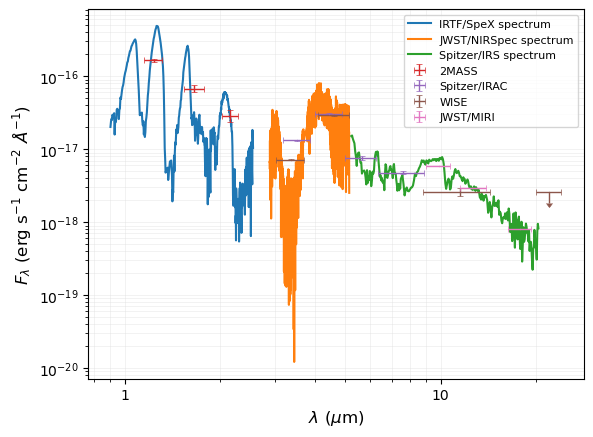

In [8]:
fig, ax = plt.subplots()

# plot spectra
plt.plot(wl_SpeX, flux_SpeX, label='IRTF/SpeX spectrum')
plt.plot(wl_NIRSpec, flux_NIRSpec, label='JWST/NIRSpec spectrum')
plt.plot(wl_IRS, flux_IRS, label='Spitzer/IRS spectrum')

# plot photometry
# select 2MASS magnitudes
mask_2MASS = ['2MASS' in filt for filt in filters]
ax.errorbar(wl_eff[mask_2MASS], flux[mask_2MASS], xerr=width_eff[mask_2MASS]/2, 
            yerr=eflux[mask_2MASS], fmt='.', markersize=1., capsize=2, 
            elinewidth=1.0, markeredgewidth=0.5, label='2MASS')

# select IRAC magnitudes
mask_IRAC = ['IRAC' in filt for filt in filters]
ax.errorbar(wl_eff[mask_IRAC], flux[mask_IRAC], xerr=width_eff[mask_IRAC]/2, 
            yerr=eflux[mask_IRAC], fmt='.', markersize=1., capsize=2, 
            elinewidth=1.0, markeredgewidth=0.5, label='Spitzer/IRAC')

# select WISE magnitudes
mask_WISE = ['WISE' in filt for filt in filters]
# handle upper limits
uplims = (ephot==0) * 1 # upper limits (null errors) indicated by 1
eflux[eflux==0] = 0.3*flux[eflux==0] # size of the arrow indicating upper limits
# plot WISE with upper limits
ax.errorbar(wl_eff[mask_WISE], flux[mask_WISE], xerr=width_eff[mask_WISE]/2, 
            yerr=eflux[mask_WISE], fmt='.', markersize=1., capsize=2, 
            elinewidth=1.0, markeredgewidth=0.5, label='WISE',
            uplims=uplims[mask_WISE])

# select MIRI magnitudes
mask_JWST = ['JWST' in filt for filt in filters]
ax.errorbar(wl_eff[mask_JWST], flux[mask_JWST], xerr=width_eff[mask_JWST]/2, 
            yerr=eflux[mask_JWST], fmt='.', markersize=1., capsize=2, 
            elinewidth=1.0, markeredgewidth=0.5, label='JWST/MIRI')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.xscale('log')
plt.yscale('log')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))

ax.grid(True, which='both', color='gainsboro', linewidth=0.5, alpha=0.5)
ax.legend(fontsize=8)

plt.xlabel(r'$\lambda\ (\mu$m)', size=12)
plt.ylabel(r'$F_\lambda\ ($erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)', size=12)

plt.show()

**Read input data**

Look at the input parameters [here](https://seda.readthedocs.io/en/latest/api.html#seda.input_parameters.InputData).

For any SEDA function, we can also see the function description directly on the notebook with the command ``help()``, e.g.:

``help(seda.input_parameters.InputData)``

In [9]:
# spectra
#--------
# wavelenghts
wl_spectra = [wl_SpeX, wl_NIRSpec, wl_IRS] # in um
# fluxes
flux_spectra = [flux_SpeX, flux_NIRSpec, flux_IRS] # in erg/s/cm2/A
# flux uncertainties
eflux_spectra = [eflux_SpeX, eflux_NIRSpec, eflux_IRS] # in erg/s/cm2/A
# specify flux units
flux_unit = 'erg/s/cm2/A'

# resolution of each input spectrum (used to convolve the model spectra)
res = [100, 2700, 100] # SpeX, NIRSpec, IRS

# photometry
#-----------
# input photometry
phot = phot
ephot = ephot
filters = filters
phot_unit = 'mag'

# distance to the target (optional and used to derive a radius)
distance = 5.71 # pc (parallax=175.2+-1.7; Dupuy-Liu2012)
edistance = 0.06 # pc

# load all the input data parameters
my_data = seda.input_parameters.InputData(wl_spectra=wl_spectra, 
                                          flux_spectra=flux_spectra, 
                                          eflux_spectra=eflux_spectra, 
                                          flux_unit=flux_unit, 
                                          res=res, 
                                          phot=phot, 
                                          ephot=ephot, 
                                          filters=filters, 
                                          phot_unit=phot_unit, 
                                          fit_photometry=True, 
                                          distance=distance, 
                                          edistance=edistance)

Null photometric errors for ['WISE/WISE.W4'] magnitudes, so they will be discarded.

   Input data loaded successfully:
      3 spectra
      13 magnitudes


Download (if not yet) the atmospheric models you want to use. 

Use the commands below to see the available atmospheric models, the links to download them, and other relevant information from models. You can read more about the model [here](https://seda.readthedocs.io/en/latest/overview.html#available-atmospheric-models).

Also consider [this tutorial](https://seda.readthedocs.io/en/latest/notebooks/tutorial_models_examination.html) to explore the free parameters in the models and their coverage.

In [10]:
# available atmospheric models
seda.models.Models().available_models

['BT-Settl',
 'ATMO2020',
 'Sonora_Elf_Owl',
 'SM08',
 'Sonora_Bobcat',
 'Sonora_Diamondback',
 'Sonora_Cholla',
 'LB23']

In [12]:
# some parameters of interest from a selected model
model = 'Sonora_Elf_Owl'
print(seda.models.Models(model).ref) # reference
print(seda.models.Models(model).ADS) # link to paper
print(seda.models.Models(model).download) # link to download the models
seda.models.Models(model).params_unique # coverage of free parameters in the grid

Mukherjee et al. (2024)
https://ui.adsabs.harvard.edu/abs/2024ApJ...963...73M/abstract
['https://zenodo.org/records/10385987', 'https://zenodo.org/records/10385821', 'https://zenodo.org/records/10381250']


{'Teff': array([ 275.,  300.,  325.,  350.,  375.,  400.,  425.,  450.,  475.,
         500.,  525.,  550.,  575.,  600.,  650.,  700.,  750.,  800.,
         850.,  900.,  950., 1000., 1100., 1200., 1300., 1400., 1500.,
        1600., 1700., 1800., 1900., 2000., 2100., 2200., 2300., 2400.]),
 'logg': array([3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25, 5.5 ]),
 'logKzz': array([2., 4., 7., 8., 9.]),
 'Z': array([-1. , -0.5,  0. ,  0.5,  0.7,  1. ]),
 'CtoO': array([0.5, 1. , 1.5, 2. , 2.5])}

**Read model grid options**

Look at the input parameters [here](https://seda.readthedocs.io/en/latest/api.html#seda.input_parameters.ModelOptions).

In [15]:
# select the atmospheric models of interest
model = 'ATMO2020'

# path to the directory or directories containing the model spectra
# (update it to your own path)'
model_dir = ['/home/gsuarez/TRABAJO/MODELS/atmosphere_models/ATMO2020/atmosphere_models/CEQ_spectra/',
             '/home/gsuarez/TRABAJO/MODELS/atmosphere_models/ATMO2020/atmosphere_models/NEQ_weak_spectra/',
             '/home/gsuarez/TRABAJO/MODELS/atmosphere_models/ATMO2020/atmosphere_models/NEQ_strong_spectra/',
            ]

# set parameter ranges to select a grid subset and to be used as uniform priors
# when a free parameter range is not specified, the whole grid range will be explored
params_ranges = {
    'Teff': [700, 800], # Teff range
    'logg': [4.0, 5.0] # logg range
}

# load model options
my_model = seda.input_parameters.ModelOptions(model=model, 
                                              model_dir=model_dir, 
                                              params_ranges=params_ranges)


   Model options loaded successfully


**Tip:** If you plan to model several spectra from the same instrument (same resolution), you can save the convolved model spectra to reuse them and do subsequent fits much faster. For this, set the parameter ``path_save_spectra_conv`` in ``seda.ModelOptions`` above to a folder path where you want to store the convolved spectra. Once the spectra are stored, the next time you run the code just replace ``model_dir`` by the path you used in ``path_save_spectra_conv`` and set ``skip_convolution=True`` to avoid the model convolution. This was implemented thanks to this [issue](https://github.com/suarezgenaro/seda/issues/14).

**Read Bayes fit options**

Look at the input parameters [here](https://seda.readthedocs.io/en/latest/api.html#seda.input_parameters.BayesOptions).

Consider the default full wavelength range of each input spectrum for the fits. Otherwise, we can use the parameter ``fit_wl_range`` to set different fit ranges.

In [16]:
# choose a filename (optional) to save the sampling results as a pickle file
# it is convenient to set a non-default name when running 
# the code several times in the same folder to avoid overwriting results
bayes_pickle_file = f'{model}_bayesian_sampling_spectrophotometry.pickle'

# radius range for the sampling
R_range = np.array((0.6, 1.0)) # Rjup

my_bayes = seda.input_parameters.BayesOptions(my_data=my_data, 
                                              my_model=my_model, 
                                              R_range=R_range, 
                                              bayes_pickle_file=bayes_pickle_file)


For input spectrum 1 of 3

      18 model spectra selected with:
         Teff range = [700, 800]
         logg range = [4.0, 5.0]


Reading, convolving, and resampling model grid:   0%|          | 0/18 [00:00<?, ?it/s]

      elapsed time: 0.0 s

For input spectrum 2 of 3

      18 model spectra selected with:
         Teff range = [700, 800]
         logg range = [4.0, 5.0]


Reading, convolving, and resampling model grid:   0%|          | 0/18 [00:00<?, ?it/s]

            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.

Reading, convolving, and resampling model grid:   0%|          | 0/18 [00:00<?, ?it/s]

      elapsed time: 0.0 s

      13 of 13 input valid magnitudes within the fit range "fit_phot_range"

      18 model spectra selected with:
         Teff range = [700, 800]
         logg range = [4.0, 5.0]


Deriving synthetic photometry from model spectra:   0%|          | 0/18 [00:00<?, ?it/s]

      elapsed time: 2.1 min

   Bayes fit options loaded successfully


**Run nested sampling**

In [17]:
out_bayes = seda.bayes_fit.bayes(my_bayes)


   Estimate Bayesian posteriors

      Uniform priors:
         Teff range = [700. 800.]
         logg range = [4. 5.]
         logKzz range = [0. 6.]
         R range = [0.6 1. ]

   Starting dynesty...



0it [00:00, ?it/s]
1it [00:02,  2.42s/it, batch: 0 | bound: 0 | nc: 1 | ncall: 1 | eff(%):  0.200 | loglstar:   -inf < 149717.230 <    inf | logz: 149710.320 +/-  0.117 | dlogz:    inf >  0.010]
21it [00:02, 11.53it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 21 | eff(%):  4.031 | loglstar:   -inf < 151625.575 <    inf | logz: 151618.626 +/-  0.118 | dlogz: 7910.575 >  0.010]
40it [00:02, 24.67it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 41 | eff(%):  7.394 | loglstar:   -inf < 152482.170 <    inf | logz: 152475.211 +/-  0.117 | dlogz: 7033.100 >  0.010]
57it [00:02, 38.41it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 61 | eff(%): 10.160 | loglstar:   -inf < 152849.012 <    inf | logz: 152841.991 +/-  0.118 | dlogz: 6685.043 >  0.010]
75it [00:02, 55.13it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 81 | eff(%): 12.909 | loglstar:   -inf < 153710.726 <    inf | logz: 153703.668 +/-  0.119 | dlogz: 5921.981 >  0.010]
92it [00:02, 70.93it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 102 | eff(%): 15.282 | 

568it [00:07, 74.03it/s, batch: 0 | bound: 0 | nc: 7 | ncall: 1050 | eff(%): 36.645 | loglstar:   -inf < 158487.318 <    inf | logz: 158479.340 +/-  0.124 | dlogz: 1026.670 >  0.010]
576it [00:07, 74.82it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 1071 | eff(%): 36.665 | loglstar:   -inf < 158508.733 <    inf | logz: 158501.071 +/-  0.120 | dlogz: 1003.736 >  0.010]
584it [00:07, 65.73it/s, batch: 0 | bound: 0 | nc: 5 | ncall: 1102 | eff(%): 36.454 | loglstar:   -inf < 158536.267 <    inf | logz: 158528.207 +/-  0.126 | dlogz: 979.496 >  0.010] 
592it [00:08, 67.07it/s, batch: 0 | bound: 0 | nc: 4 | ncall: 1124 | eff(%): 36.453 | loglstar:   -inf < 158558.576 <    inf | logz: 158550.487 +/-  0.127 | dlogz: 959.235 >  0.010]
599it [00:08, 66.37it/s, batch: 0 | bound: 0 | nc: 3 | ncall: 1145 | eff(%): 36.413 | loglstar:   -inf < 158576.384 <    inf | logz: 158569.379 +/-  0.113 | dlogz: 934.265 >  0.010]
606it [00:08, 58.81it/s, batch: 0 | bound: 0 | nc: 4 | ncall: 1176 | eff(%): 36.158 | l

855it [00:13, 30.54it/s, batch: 0 | bound: 0 | nc: 4 | ncall: 2313 | eff(%): 30.395 | loglstar:   -inf < 159026.018 <    inf | logz: 159019.225 +/-  0.112 | dlogz: 487.150 >  0.010] 
862it [00:13, 37.46it/s, batch: 0 | bound: 0 | nc: 3 | ncall: 2336 | eff(%): 30.395 | loglstar:   -inf < 159033.877 <    inf | logz: 159026.323 +/-  0.121 | dlogz: 480.711 >  0.010]
867it [00:14, 39.46it/s, batch: 0 | bound: 0 | nc: 2 | ncall: 2358 | eff(%): 30.336 | loglstar:   -inf < 159036.999 <    inf | logz: 159029.361 +/-  0.115 | dlogz: 477.340 >  0.010]
875it [00:14, 47.48it/s, batch: 0 | bound: 0 | nc: 4 | ncall: 2381 | eff(%): 30.371 | loglstar:   -inf < 159046.333 <    inf | logz: 159039.151 +/-  0.116 | dlogz: 467.404 >  0.010]
881it [00:14, 46.38it/s, batch: 0 | bound: 0 | nc: 6 | ncall: 2409 | eff(%): 30.285 | loglstar:   -inf < 159048.887 <    inf | logz: 159041.952 +/-  0.112 | dlogz: 464.427 >  0.010]
886it [00:14, 40.35it/s, batch: 0 | bound: 0 | nc: 4 | ncall: 2444 | eff(%): 30.095 | log

1059it [00:20, 21.83it/s, batch: 0 | bound: 0 | nc: 11 | ncall: 3644 | eff(%): 25.555 | loglstar:   -inf < 159189.940 <    inf | logz: 159182.403 +/-  0.113 | dlogz: 332.474 >  0.010]
1064it [00:20, 25.79it/s, batch: 0 | bound: 0 | nc: 10 | ncall: 3673 | eff(%): 25.497 | loglstar:   -inf < 159192.384 <    inf | logz: 159184.900 +/-  0.116 | dlogz: 330.056 >  0.010]
1067it [00:20, 22.27it/s, batch: 0 | bound: 0 | nc: 13 | ncall: 3712 | eff(%): 25.332 | loglstar:   -inf < 159193.063 <    inf | logz: 159185.903 +/-  0.113 | dlogz: 328.850 >  0.010]
1071it [00:20, 25.42it/s, batch: 0 | bound: 0 | nc: 5 | ncall: 3735 | eff(%): 25.289 | loglstar:   -inf < 159194.090 <    inf | logz: 159187.057 +/-  0.111 | dlogz: 327.659 >  0.010] 
1077it [00:20, 33.09it/s, batch: 0 | bound: 0 | nc: 5 | ncall: 3756 | eff(%): 25.305 | loglstar:   -inf < 159195.283 <    inf | logz: 159188.302 +/-  0.109 | dlogz: 329.200 >  0.010]
1082it [00:21, 25.92it/s, batch: 0 | bound: 0 | nc: 40 | ncall: 3814 | eff(%): 25

1230it [00:27, 16.25it/s, batch: 0 | bound: 0 | nc: 16 | ncall: 5113 | eff(%): 21.913 | loglstar:   -inf < 159266.120 <    inf | logz: 159257.957 +/-  0.117 | dlogz: 265.378 >  0.010]
1232it [00:27, 16.74it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 5135 | eff(%): 21.863 | loglstar:   -inf < 159266.587 <    inf | logz: 159258.834 +/-  0.117 | dlogz: 264.373 >  0.010] 
1234it [00:28, 11.27it/s, batch: 0 | bound: 0 | nc: 35 | ncall: 5208 | eff(%): 21.619 | loglstar:   -inf < 159267.507 <    inf | logz: 159259.734 +/-  0.117 | dlogz: 263.513 >  0.010]
1236it [00:28, 11.20it/s, batch: 0 | bound: 0 | nc: 16 | ncall: 5245 | eff(%): 21.514 | loglstar:   -inf < 159268.287 <    inf | logz: 159260.561 +/-  0.117 | dlogz: 262.645 >  0.010]
1238it [00:28, 11.88it/s, batch: 0 | bound: 0 | nc: 4 | ncall: 5274 | eff(%): 21.441 | loglstar:   -inf < 159268.689 <    inf | logz: 159261.194 +/-  0.116 | dlogz: 261.903 >  0.010] 
1241it [00:28, 11.83it/s, batch: 0 | bound: 0 | nc: 35 | ncall: 5327 | eff(%): 2

1355it [00:36,  8.01it/s, batch: 0 | bound: 0 | nc: 40 | ncall: 6857 | eff(%): 18.418 | loglstar:   -inf < 159304.448 <    inf | logz: 159296.913 +/-  0.117 | dlogz: 225.917 >  0.010]
1359it [00:36, 11.08it/s, batch: 0 | bound: 0 | nc: 26 | ncall: 6897 | eff(%): 18.372 | loglstar:   -inf < 159306.258 <    inf | logz: 159298.417 +/-  0.118 | dlogz: 224.498 >  0.010]
1361it [00:36, 11.50it/s, batch: 0 | bound: 0 | nc: 6 | ncall: 6929 | eff(%): 18.320 | loglstar:   -inf < 159306.405 <    inf | logz: 159298.966 +/-  0.117 | dlogz: 223.832 >  0.010] 
1363it [00:36, 11.83it/s, batch: 0 | bound: 0 | nc: 16 | ncall: 6961 | eff(%): 18.268 | loglstar:   -inf < 159306.886 <    inf | logz: 159299.460 +/-  0.116 | dlogz: 223.330 >  0.010]
1365it [00:36, 12.02it/s, batch: 0 | bound: 0 | nc: 28 | ncall: 6994 | eff(%): 18.215 | loglstar:   -inf < 159307.770 <    inf | logz: 159300.037 +/-  0.116 | dlogz: 222.811 >  0.010]
1369it [00:36, 16.34it/s, batch: 0 | bound: 0 | nc: 9 | ncall: 7021 | eff(%): 18

1465it [00:44, 10.23it/s, batch: 0 | bound: 0 | nc: 9 | ncall: 8632 | eff(%): 16.042 | loglstar:   -inf < 159334.300 <    inf | logz: 159327.030 +/-  0.115 | dlogz: 195.479 >  0.010] 
1467it [00:44,  9.49it/s, batch: 0 | bound: 0 | nc: 31 | ncall: 8681 | eff(%): 15.979 | loglstar:   -inf < 159334.472 <    inf | logz: 159327.318 +/-  0.114 | dlogz: 195.161 >  0.010]
1469it [00:45,  8.30it/s, batch: 0 | bound: 0 | nc: 33 | ncall: 8745 | eff(%): 15.890 | loglstar:   -inf < 159335.689 <    inf | logz: 159327.845 +/-  0.115 | dlogz: 194.781 >  0.010]
1471it [00:45,  9.29it/s, batch: 0 | bound: 0 | nc: 12 | ncall: 8777 | eff(%): 15.856 | loglstar:   -inf < 159336.171 <    inf | logz: 159328.365 +/-  0.116 | dlogz: 194.224 >  0.010]
1473it [00:45,  7.70it/s, batch: 0 | bound: 0 | nc: 58 | ncall: 8851 | eff(%): 15.752 | loglstar:   -inf < 159336.588 <    inf | logz: 159328.848 +/-  0.116 | dlogz: 193.717 >  0.010]
1476it [00:45,  8.79it/s, batch: 0 | bound: 0 | nc: 41 | ncall: 8904 | eff(%): 1

1571it [00:54,  9.61it/s, batch: 0 | bound: 0 | nc: 13 | ncall: 10569 | eff(%): 14.193 | loglstar:   -inf < 159359.788 <    inf | logz: 159352.478 +/-  0.115 | dlogz: 169.791 >  0.010]
1573it [00:54,  9.82it/s, batch: 0 | bound: 0 | nc: 16 | ncall: 10609 | eff(%): 14.160 | loglstar:   -inf < 159360.177 <    inf | logz: 159352.747 +/-  0.115 | dlogz: 169.519 >  0.010]
1575it [00:54,  9.31it/s, batch: 0 | bound: 0 | nc: 13 | ncall: 10659 | eff(%): 14.114 | loglstar:   -inf < 159360.899 <    inf | logz: 159353.164 +/-  0.115 | dlogz: 169.177 >  0.010]
1577it [00:54, 11.04it/s, batch: 0 | bound: 0 | nc: 3 | ncall: 10680 | eff(%): 14.106 | loglstar:   -inf < 159361.227 <    inf | logz: 159353.554 +/-  0.116 | dlogz: 168.757 >  0.010] 
1579it [00:55,  7.10it/s, batch: 0 | bound: 0 | nc: 63 | ncall: 10784 | eff(%): 13.993 | loglstar:   -inf < 159361.475 <    inf | logz: 159353.895 +/-  0.115 | dlogz: 168.387 >  0.010]
1581it [00:55,  7.61it/s, batch: 0 | bound: 0 | nc: 27 | ncall: 10826 | eff

1653it [01:04,  7.62it/s, batch: 0 | bound: 0 | nc: 29 | ncall: 12576 | eff(%): 12.641 | loglstar:   -inf < 159376.306 <    inf | logz: 159368.414 +/-  0.117 | dlogz: 154.605 >  0.010]
1654it [01:04,  5.28it/s, batch: 0 | bound: 0 | nc: 76 | ncall: 12652 | eff(%): 12.576 | loglstar:   -inf < 159376.777 <    inf | logz: 159368.642 +/-  0.117 | dlogz: 154.413 >  0.010]
1657it [01:04,  8.90it/s, batch: 0 | bound: 0 | nc: 5 | ncall: 12677 | eff(%): 12.575 | loglstar:   -inf < 159377.602 <    inf | logz: 159369.374 +/-  0.118 | dlogz: 153.701 >  0.010] 
1659it [01:04,  7.70it/s, batch: 0 | bound: 0 | nc: 8 | ncall: 12746 | eff(%): 12.525 | loglstar:   -inf < 159377.978 <    inf | logz: 159369.867 +/-  0.119 | dlogz: 153.190 >  0.010]
1661it [01:05,  8.35it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 12787 | eff(%): 12.501 | loglstar:   -inf < 159378.912 <    inf | logz: 159370.451 +/-  0.120 | dlogz: 152.681 >  0.010]
1663it [01:05,  6.50it/s, batch: 0 | bound: 0 | nc: 39 | ncall: 12883 | eff(%

1725it [01:15,  4.36it/s, batch: 0 | bound: 0 | nc: 42 | ncall: 14915 | eff(%): 11.190 | loglstar:   -inf < 159391.861 <    inf | logz: 159383.666 +/-  0.119 | dlogz: 139.224 >  0.010]
1726it [01:15,  4.32it/s, batch: 0 | bound: 0 | nc: 50 | ncall: 14965 | eff(%): 11.161 | loglstar:   -inf < 159391.951 <    inf | logz: 159383.882 +/-  0.119 | dlogz: 139.017 >  0.010]
1727it [01:15,  4.56it/s, batch: 0 | bound: 0 | nc: 37 | ncall: 15002 | eff(%): 11.140 | loglstar:   -inf < 159392.241 <    inf | logz: 159384.095 +/-  0.119 | dlogz: 138.799 >  0.010]
1729it [01:15,  5.84it/s, batch: 0 | bound: 0 | nc: 34 | ncall: 15043 | eff(%): 11.124 | loglstar:   -inf < 159393.103 <    inf | logz: 159384.624 +/-  0.120 | dlogz: 138.340 >  0.010]
1731it [01:17,  3.19it/s, batch: 0 | bound: 0 | nc: 218 | ncall: 15269 | eff(%): 10.977 | loglstar:   -inf < 159393.586 <    inf | logz: 159385.214 +/-  0.121 | dlogz: 137.746 >  0.010]
1732it [01:17,  3.41it/s, batch: 0 | bound: 0 | nc: 44 | ncall: 15313 | ef

1795it [01:26,  6.11it/s, batch: 0 | bound: 0 | nc: 41 | ncall: 17110 | eff(%): 10.193 | loglstar:   -inf < 159406.358 <    inf | logz: 159397.854 +/-  0.121 | dlogz: 124.996 >  0.010]
1796it [01:26,  5.06it/s, batch: 0 | bound: 0 | nc: 63 | ncall: 17173 | eff(%): 10.162 | loglstar:   -inf < 159406.674 <    inf | logz: 159398.134 +/-  0.122 | dlogz: 124.690 >  0.010]
1797it [01:26,  5.44it/s, batch: 0 | bound: 0 | nc: 29 | ncall: 17202 | eff(%): 10.151 | loglstar:   -inf < 159406.686 <    inf | logz: 159398.384 +/-  0.122 | dlogz: 124.407 >  0.010]
1799it [01:26,  6.79it/s, batch: 0 | bound: 0 | nc: 27 | ncall: 17241 | eff(%): 10.140 | loglstar:   -inf < 159407.091 <    inf | logz: 159398.797 +/-  0.121 | dlogz: 123.948 >  0.010]
1802it [01:27,  8.07it/s, batch: 0 | bound: 0 | nc: 45 | ncall: 17302 | eff(%): 10.122 | loglstar:   -inf < 159407.496 <    inf | logz: 159399.377 +/-  0.120 | dlogz: 123.340 >  0.010]
1804it [01:27,  9.23it/s, batch: 0 | bound: 0 | nc: 10 | ncall: 17332 | eff

2009it [01:33, 30.97it/s, batch: 0 | bound: 2 | nc: 7 | ncall: 18453 | eff(%): 10.600 | loglstar:   -inf < 159438.704 <    inf | logz: 159430.934 +/-  0.119 | dlogz: 95.272 >  0.010]
2014it [01:33, 20.26it/s, batch: 0 | bound: 2 | nc: 13 | ncall: 18556 | eff(%): 10.569 | loglstar:   -inf < 159439.269 <    inf | logz: 159431.387 +/-  0.118 | dlogz: 94.816 >  0.010]
2018it [01:33, 22.07it/s, batch: 0 | bound: 2 | nc: 11 | ncall: 18582 | eff(%): 10.575 | loglstar:   -inf < 159439.676 <    inf | logz: 159431.767 +/-  0.118 | dlogz: 94.425 >  0.010]
2022it [01:33, 20.39it/s, batch: 0 | bound: 2 | nc: 13 | ncall: 18632 | eff(%): 10.569 | loglstar:   -inf < 159439.890 <    inf | logz: 159432.117 +/-  0.118 | dlogz: 94.059 >  0.010]
2025it [01:34, 21.17it/s, batch: 0 | bound: 2 | nc: 6 | ncall: 18657 | eff(%): 10.571 | loglstar:   -inf < 159440.244 <    inf | logz: 159432.358 +/-  0.117 | dlogz: 93.811 >  0.010] 
2028it [01:34, 18.90it/s, batch: 0 | bound: 2 | nc: 17 | ncall: 18702 | eff(%): 1

2182it [01:40, 22.52it/s, batch: 0 | bound: 4 | nc: 1 | ncall: 19923 | eff(%): 10.684 | loglstar:   -inf < 159456.307 <    inf | logz: 159448.469 +/-  0.119 | dlogz: 81.285 >  0.010]
2185it [01:40, 23.91it/s, batch: 0 | bound: 4 | nc: 4 | ncall: 19944 | eff(%): 10.688 | loglstar:   -inf < 159456.521 <    inf | logz: 159448.660 +/-  0.119 | dlogz: 81.086 >  0.010]
2188it [01:40, 21.03it/s, batch: 0 | bound: 4 | nc: 23 | ncall: 19984 | eff(%): 10.682 | loglstar:   -inf < 159456.864 <    inf | logz: 159448.875 +/-  0.119 | dlogz: 80.874 >  0.010]
2191it [01:40, 21.36it/s, batch: 0 | bound: 4 | nc: 5 | ncall: 20012 | eff(%): 10.682 | loglstar:   -inf < 159457.333 <    inf | logz: 159449.135 +/-  0.119 | dlogz: 80.623 >  0.010] 
2195it [01:40, 24.96it/s, batch: 0 | bound: 4 | nc: 2 | ncall: 20034 | eff(%): 10.690 | loglstar:   -inf < 159457.669 <    inf | logz: 159449.500 +/-  0.119 | dlogz: 80.251 >  0.010]
2201it [01:41, 31.84it/s, batch: 0 | bound: 4 | nc: 6 | ncall: 20058 | eff(%): 10.7

2385it [01:47, 44.03it/s, batch: 0 | bound: 5 | nc: 2 | ncall: 21280 | eff(%): 10.950 | loglstar:   -inf < 159473.875 <    inf | logz: 159465.709 +/-  0.121 | dlogz: 63.631 >  0.010] 
2390it [01:47, 36.66it/s, batch: 0 | bound: 5 | nc: 4 | ncall: 21321 | eff(%): 10.953 | loglstar:   -inf < 159474.420 <    inf | logz: 159466.061 +/-  0.121 | dlogz: 63.280 >  0.010]
2394it [01:47, 28.28it/s, batch: 0 | bound: 5 | nc: 11 | ncall: 21372 | eff(%): 10.946 | loglstar:   -inf < 159474.620 <    inf | logz: 159466.341 +/-  0.121 | dlogz: 62.990 >  0.010]
2400it [01:47, 31.21it/s, batch: 0 | bound: 5 | nc: 12 | ncall: 21403 | eff(%): 10.957 | loglstar:   -inf < 159474.905 <    inf | logz: 159466.717 +/-  0.121 | dlogz: 62.596 >  0.010]
2404it [01:47, 26.88it/s, batch: 0 | bound: 6 | nc: 2 | ncall: 21416 | eff(%): 10.969 | loglstar:   -inf < 159475.057 <    inf | logz: 159466.940 +/-  0.121 | dlogz: 62.358 >  0.010] 
2412it [01:48, 35.88it/s, batch: 0 | bound: 6 | nc: 12 | ncall: 21439 | eff(%): 1

2732it [01:52, 77.26it/s, batch: 0 | bound: 7 | nc: 1 | ncall: 22391 | eff(%): 11.935 | loglstar:   -inf < 159491.350 <    inf | logz: 159482.857 +/-  0.122 | dlogz: 45.774 >  0.010]
2740it [01:53, 73.46it/s, batch: 0 | bound: 7 | nc: 5 | ncall: 22416 | eff(%): 11.957 | loglstar:   -inf < 159491.839 <    inf | logz: 159483.214 +/-  0.122 | dlogz: 45.404 >  0.010]
2749it [01:53, 75.98it/s, batch: 0 | bound: 7 | nc: 5 | ncall: 22438 | eff(%): 11.984 | loglstar:   -inf < 159492.302 <    inf | logz: 159483.632 +/-  0.123 | dlogz: 44.969 >  0.010]
2757it [01:53, 75.40it/s, batch: 0 | bound: 7 | nc: 1 | ncall: 22460 | eff(%): 12.008 | loglstar:   -inf < 159492.747 <    inf | logz: 159484.015 +/-  0.123 | dlogz: 44.572 >  0.010]
2765it [01:53, 64.83it/s, batch: 0 | bound: 7 | nc: 4 | ncall: 22494 | eff(%): 12.025 | loglstar:   -inf < 159492.968 <    inf | logz: 159484.402 +/-  0.123 | dlogz: 44.164 >  0.010]
2772it [01:53, 59.24it/s, batch: 0 | bound: 7 | nc: 4 | ncall: 22524 | eff(%): 12.040

3105it [01:58, 63.41it/s, batch: 0 | bound: 9 | nc: 2 | ncall: 23870 | eff(%): 12.741 | loglstar:   -inf < 159505.179 <    inf | logz: 159496.525 +/-  0.125 | dlogz: 32.753 >  0.010] 
3113it [01:58, 64.94it/s, batch: 0 | bound: 9 | nc: 1 | ncall: 23923 | eff(%): 12.746 | loglstar:   -inf < 159505.352 <    inf | logz: 159496.709 +/-  0.125 | dlogz: 32.553 >  0.010]
3121it [01:58, 63.24it/s, batch: 0 | bound: 9 | nc: 10 | ncall: 23985 | eff(%): 12.747 | loglstar:   -inf < 159505.558 <    inf | logz: 159496.889 +/-  0.125 | dlogz: 32.358 >  0.010]
3128it [01:58, 60.80it/s, batch: 0 | bound: 9 | nc: 19 | ncall: 24044 | eff(%): 12.744 | loglstar:   -inf < 159505.677 <    inf | logz: 159497.042 +/-  0.124 | dlogz: 32.189 >  0.010]
3136it [01:59, 62.50it/s, batch: 0 | bound: 9 | nc: 11 | ncall: 24099 | eff(%): 12.748 | loglstar:   -inf < 159506.077 <    inf | logz: 159497.237 +/-  0.124 | dlogz: 31.983 >  0.010]
3145it [01:59, 68.33it/s, batch: 0 | bound: 9 | nc: 9 | ncall: 24148 | eff(%): 12

3422it [02:04, 44.14it/s, batch: 0 | bound: 11 | nc: 1 | ncall: 25386 | eff(%): 13.220 | loglstar:   -inf < 159513.035 <    inf | logz: 159503.920 +/-  0.127 | dlogz: 24.722 >  0.010] 
3428it [02:04, 46.26it/s, batch: 0 | bound: 11 | nc: 6 | ncall: 25410 | eff(%): 13.230 | loglstar:   -inf < 159513.163 <    inf | logz: 159504.036 +/-  0.127 | dlogz: 24.593 >  0.010]
3439it [02:04, 61.36it/s, batch: 0 | bound: 11 | nc: 1 | ncall: 25431 | eff(%): 13.262 | loglstar:   -inf < 159513.333 <    inf | logz: 159504.249 +/-  0.127 | dlogz: 24.358 >  0.010]
3446it [02:04, 58.50it/s, batch: 0 | bound: 11 | nc: 2 | ncall: 25459 | eff(%): 13.275 | loglstar:   -inf < 159513.499 <    inf | logz: 159504.375 +/-  0.127 | dlogz: 24.217 >  0.010]
3456it [02:04, 66.91it/s, batch: 0 | bound: 11 | nc: 3 | ncall: 25482 | eff(%): 13.302 | loglstar:   -inf < 159513.777 <    inf | logz: 159504.565 +/-  0.127 | dlogz: 24.008 >  0.010]
3464it [02:05, 50.19it/s, batch: 0 | bound: 11 | nc: 14 | ncall: 25536 | eff(%)

3675it [02:10, 30.60it/s, batch: 0 | bound: 12 | nc: 13 | ncall: 26602 | eff(%): 13.560 | loglstar:   -inf < 159517.835 <    inf | logz: 159508.503 +/-  0.129 | dlogz: 19.629 >  0.010]
3679it [02:10, 29.74it/s, batch: 0 | bound: 12 | nc: 7 | ncall: 26632 | eff(%): 13.560 | loglstar:   -inf < 159517.928 <    inf | logz: 159508.562 +/-  0.129 | dlogz: 19.562 >  0.010] 
3684it [02:10, 33.63it/s, batch: 0 | bound: 12 | nc: 3 | ncall: 26654 | eff(%): 13.567 | loglstar:   -inf < 159517.985 <    inf | logz: 159508.636 +/-  0.129 | dlogz: 19.478 >  0.010]
3688it [02:11, 23.53it/s, batch: 0 | bound: 13 | nc: 13 | ncall: 26688 | eff(%): 13.565 | loglstar:   -inf < 159518.015 <    inf | logz: 159508.693 +/-  0.129 | dlogz: 19.412 >  0.010]
3691it [02:11, 23.05it/s, batch: 0 | bound: 13 | nc: 5 | ncall: 26715 | eff(%): 13.562 | loglstar:   -inf < 159518.033 <    inf | logz: 159508.735 +/-  0.129 | dlogz: 19.364 >  0.010] 
3695it [02:11, 25.63it/s, batch: 0 | bound: 13 | nc: 4 | ncall: 26736 | eff(

3904it [02:16, 55.62it/s, batch: 0 | bound: 14 | nc: 1 | ncall: 28011 | eff(%): 13.693 | loglstar:   -inf < 159521.159 <    inf | logz: 159511.557 +/-  0.131 | dlogz: 16.114 >  0.010]
3911it [02:17, 53.10it/s, batch: 0 | bound: 14 | nc: 1 | ncall: 28040 | eff(%): 13.704 | loglstar:   -inf < 159521.315 <    inf | logz: 159511.644 +/-  0.131 | dlogz: 16.014 >  0.010]
3919it [02:17, 58.57it/s, batch: 0 | bound: 14 | nc: 4 | ncall: 28060 | eff(%): 13.722 | loglstar:   -inf < 159521.401 <    inf | logz: 159511.743 +/-  0.131 | dlogz: 15.898 >  0.010]
3926it [02:17, 51.88it/s, batch: 0 | bound: 14 | nc: 11 | ncall: 28096 | eff(%): 13.729 | loglstar:   -inf < 159521.494 <    inf | logz: 159511.830 +/-  0.131 | dlogz: 15.798 >  0.010]
3932it [02:17, 42.41it/s, batch: 0 | bound: 14 | nc: 7 | ncall: 28141 | eff(%): 13.729 | loglstar:   -inf < 159521.606 <    inf | logz: 159511.905 +/-  0.131 | dlogz: 15.711 >  0.010] 
3937it [02:17, 33.20it/s, batch: 0 | bound: 15 | nc: 4 | ncall: 28165 | eff(%)

4216it [02:22, 48.74it/s, batch: 0 | bound: 16 | nc: 6 | ncall: 29141 | eff(%): 14.224 | loglstar:   -inf < 159525.028 <    inf | logz: 159515.094 +/-  0.133 | dlogz: 11.951 >  0.010]
4222it [02:22, 49.04it/s, batch: 0 | bound: 16 | nc: 5 | ncall: 29166 | eff(%): 14.232 | loglstar:   -inf < 159525.066 <    inf | logz: 159515.148 +/-  0.133 | dlogz: 11.885 >  0.010]
4228it [02:23, 41.77it/s, batch: 0 | bound: 16 | nc: 6 | ncall: 29208 | eff(%): 14.232 | loglstar:   -inf < 159525.091 <    inf | logz: 159515.199 +/-  0.133 | dlogz: 11.821 >  0.010]
4233it [02:23, 39.06it/s, batch: 0 | bound: 16 | nc: 2 | ncall: 29240 | eff(%): 14.233 | loglstar:   -inf < 159525.134 <    inf | logz: 159515.241 +/-  0.133 | dlogz: 11.769 >  0.010]
4239it [02:23, 42.54it/s, batch: 0 | bound: 16 | nc: 4 | ncall: 29263 | eff(%): 14.243 | loglstar:   -inf < 159525.152 <    inf | logz: 159515.290 +/-  0.133 | dlogz: 11.708 >  0.010]
4248it [02:23, 53.21it/s, batch: 0 | bound: 16 | nc: 1 | ncall: 29284 | eff(%): 

4535it [02:28, 50.52it/s, batch: 0 | bound: 18 | nc: 5 | ncall: 30669 | eff(%): 14.550 | loglstar:   -inf < 159527.803 <    inf | logz: 159517.543 +/-  0.135 | dlogz:  8.868 >  0.010]
4541it [02:28, 48.42it/s, batch: 0 | bound: 18 | nc: 3 | ncall: 30698 | eff(%): 14.555 | loglstar:   -inf < 159527.848 <    inf | logz: 159517.583 +/-  0.135 | dlogz:  8.817 >  0.010]
4548it [02:28, 52.78it/s, batch: 0 | bound: 18 | nc: 2 | ncall: 30720 | eff(%): 14.568 | loglstar:   -inf < 159527.936 <    inf | logz: 159517.629 +/-  0.135 | dlogz:  8.756 >  0.010]
4554it [02:29, 49.20it/s, batch: 0 | bound: 18 | nc: 2 | ncall: 30750 | eff(%): 14.573 | loglstar:   -inf < 159527.991 <    inf | logz: 159517.670 +/-  0.135 | dlogz:  8.704 >  0.010]
4560it [02:29, 51.13it/s, batch: 0 | bound: 18 | nc: 4 | ncall: 30772 | eff(%): 14.582 | loglstar:   -inf < 159528.032 <    inf | logz: 159517.711 +/-  0.135 | dlogz:  8.651 >  0.010]
4568it [02:29, 55.65it/s, batch: 0 | bound: 18 | nc: 5 | ncall: 30797 | eff(%): 

4750it [02:35, 28.36it/s, batch: 0 | bound: 20 | nc: 2 | ncall: 31939 | eff(%): 14.643 | loglstar:   -inf < 159529.271 <    inf | logz: 159518.833 +/-  0.136 | dlogz:  7.148 >  0.010]
4755it [02:35, 29.82it/s, batch: 0 | bound: 20 | nc: 11 | ncall: 31970 | eff(%): 14.644 | loglstar:   -inf < 159529.287 <    inf | logz: 159518.859 +/-  0.136 | dlogz:  7.112 >  0.010]
4759it [02:35, 25.53it/s, batch: 0 | bound: 20 | nc: 7 | ncall: 32016 | eff(%): 14.636 | loglstar:   -inf < 159529.312 <    inf | logz: 159518.879 +/-  0.136 | dlogz:  7.084 >  0.010] 
4764it [02:35, 27.44it/s, batch: 0 | bound: 20 | nc: 13 | ncall: 32048 | eff(%): 14.637 | loglstar:   -inf < 159529.332 <    inf | logz: 159518.904 +/-  0.137 | dlogz:  7.049 >  0.010]
4768it [02:35, 29.59it/s, batch: 0 | bound: 20 | nc: 2 | ncall: 32070 | eff(%): 14.639 | loglstar:   -inf < 159529.349 <    inf | logz: 159518.924 +/-  0.137 | dlogz:  7.021 >  0.010] 
4773it [02:35, 30.97it/s, batch: 0 | bound: 20 | nc: 17 | ncall: 32100 | eff

5208it [02:40, 108.93it/s, batch: 0 | bound: 22 | nc: 5 | ncall: 33804 | eff(%): 15.182 | loglstar:   -inf < 159531.547 <    inf | logz: 159520.652 +/-  0.139 | dlogz:  4.423 >  0.010]
5220it [02:40, 102.59it/s, batch: 0 | bound: 22 | nc: 4 | ncall: 33859 | eff(%): 15.193 | loglstar:   -inf < 159531.589 <    inf | logz: 159520.691 +/-  0.139 | dlogz:  4.361 >  0.010]
5231it [02:40, 96.38it/s, batch: 0 | bound: 22 | nc: 3 | ncall: 33912 | eff(%): 15.201 | loglstar:   -inf < 159531.632 <    inf | logz: 159520.726 +/-  0.139 | dlogz:  4.304 >  0.010] 
5243it [02:40, 100.23it/s, batch: 0 | bound: 22 | nc: 5 | ncall: 33956 | eff(%): 15.217 | loglstar:   -inf < 159531.681 <    inf | logz: 159520.764 +/-  0.139 | dlogz:  4.244 >  0.010]
5254it [02:41, 94.22it/s, batch: 0 | bound: 22 | nc: 10 | ncall: 34010 | eff(%): 15.225 | loglstar:   -inf < 159531.752 <    inf | logz: 159520.798 +/-  0.139 | dlogz:  4.188 >  0.010]
5264it [02:41, 94.26it/s, batch: 0 | bound: 22 | nc: 5 | ncall: 34048 | eff

5537it [02:46, 58.98it/s, batch: 0 | bound: 24 | nc: 7 | ncall: 35552 | eff(%): 15.358 | loglstar:   -inf < 159532.739 <    inf | logz: 159521.561 +/-  0.141 | dlogz:  2.900 >  0.010] 
5546it [02:46, 64.76it/s, batch: 0 | bound: 24 | nc: 7 | ncall: 35586 | eff(%): 15.369 | loglstar:   -inf < 159532.771 <    inf | logz: 159521.581 +/-  0.141 | dlogz:  2.864 >  0.010]
5553it [02:46, 40.15it/s, batch: 0 | bound: 25 | nc: 6 | ncall: 35675 | eff(%): 15.350 | loglstar:   -inf < 159532.782 <    inf | logz: 159521.597 +/-  0.141 | dlogz:  2.837 >  0.010]
5564it [02:47, 52.34it/s, batch: 0 | bound: 25 | nc: 2 | ncall: 35710 | eff(%): 15.366 | loglstar:   -inf < 159532.808 <    inf | logz: 159521.621 +/-  0.141 | dlogz:  2.793 >  0.010]
5572it [02:47, 56.95it/s, batch: 0 | bound: 25 | nc: 4 | ncall: 35747 | eff(%): 15.372 | loglstar:   -inf < 159532.833 <    inf | logz: 159521.638 +/-  0.141 | dlogz:  2.762 >  0.010]
5580it [02:47, 59.52it/s, batch: 0 | bound: 25 | nc: 5 | ncall: 35789 | eff(%):

5938it [02:51, 113.20it/s, batch: 0 | bound: 27 | nc: 2 | ncall: 37328 | eff(%): 15.697 | loglstar:   -inf < 159533.604 <    inf | logz: 159522.230 +/-  0.142 | dlogz:  1.598 >  0.010]
5951it [02:51, 112.47it/s, batch: 0 | bound: 27 | nc: 10 | ncall: 37368 | eff(%): 15.715 | loglstar:   -inf < 159533.623 <    inf | logz: 159522.246 +/-  0.142 | dlogz:  1.565 >  0.010]
5963it [02:52, 109.76it/s, batch: 0 | bound: 27 | nc: 7 | ncall: 37408 | eff(%): 15.730 | loglstar:   -inf < 159533.643 <    inf | logz: 159522.260 +/-  0.142 | dlogz:  1.535 >  0.010] 
5975it [02:52, 110.74it/s, batch: 0 | bound: 27 | nc: 1 | ncall: 37446 | eff(%): 15.746 | loglstar:   -inf < 159533.667 <    inf | logz: 159522.274 +/-  0.142 | dlogz:  1.505 >  0.010]
5987it [02:52, 104.47it/s, batch: 0 | bound: 27 | nc: 2 | ncall: 37494 | eff(%): 15.758 | loglstar:   -inf < 159533.681 <    inf | logz: 159522.288 +/-  0.142 | dlogz:  1.476 >  0.010]
5998it [02:52, 105.90it/s, batch: 0 | bound: 27 | nc: 3 | ncall: 37530 | 

6502it [02:56, 121.81it/s, batch: 0 | bound: 29 | nc: 6 | ncall: 39158 | eff(%): 16.395 | loglstar:   -inf < 159534.455 <    inf | logz: 159522.708 +/-  0.143 | dlogz:  0.584 >  0.010]
6517it [02:57, 129.41it/s, batch: 0 | bound: 29 | nc: 3 | ncall: 39193 | eff(%): 16.419 | loglstar:   -inf < 159534.465 <    inf | logz: 159522.717 +/-  0.143 | dlogz:  0.567 >  0.010]
6531it [02:57, 111.84it/s, batch: 0 | bound: 29 | nc: 1 | ncall: 39253 | eff(%): 16.429 | loglstar:   -inf < 159534.483 <    inf | logz: 159522.725 +/-  0.143 | dlogz:  0.552 >  0.010]
6544it [02:57, 114.65it/s, batch: 0 | bound: 29 | nc: 4 | ncall: 39292 | eff(%): 16.446 | loglstar:   -inf < 159534.492 <    inf | logz: 159522.732 +/-  0.143 | dlogz:  0.538 >  0.010]
6556it [02:57, 109.85it/s, batch: 0 | bound: 29 | nc: 1 | ncall: 39337 | eff(%): 16.457 | loglstar:   -inf < 159534.500 <    inf | logz: 159522.738 +/-  0.143 | dlogz:  0.526 >  0.010]
6568it [02:57, 77.14it/s, batch: 0 | bound: 30 | nc: 1 | ncall: 39413 | eff

7283it [03:02, 127.33it/s, batch: 0 | bound: 32 | nc: 6 | ncall: 41047 | eff(%): 17.530 | loglstar:   -inf < 159535.035 <    inf | logz: 159522.967 +/-  0.144 | dlogz:  0.124 >  0.010]
7297it [03:02, 126.77it/s, batch: 0 | bound: 32 | nc: 1 | ncall: 41089 | eff(%): 17.546 | loglstar:   -inf < 159535.042 <    inf | logz: 159522.969 +/-  0.144 | dlogz:  0.120 >  0.010]
7310it [03:02, 116.02it/s, batch: 0 | bound: 32 | nc: 1 | ncall: 41138 | eff(%): 17.556 | loglstar:   -inf < 159535.052 <    inf | logz: 159522.971 +/-  0.144 | dlogz:  0.117 >  0.010]
7322it [03:02, 105.21it/s, batch: 0 | bound: 32 | nc: 2 | ncall: 41192 | eff(%): 17.562 | loglstar:   -inf < 159535.058 <    inf | logz: 159522.973 +/-  0.144 | dlogz:  0.114 >  0.010]
7333it [03:02, 100.48it/s, batch: 0 | bound: 32 | nc: 6 | ncall: 41238 | eff(%): 17.569 | loglstar:   -inf < 159535.064 <    inf | logz: 159522.975 +/-  0.144 | dlogz:  0.112 >  0.010]
7347it [03:02, 106.79it/s, batch: 0 | bound: 32 | nc: 8 | ncall: 41280 | ef

8082it [03:07, 157.19it/s, batch: 0 | bound: 34 | nc: 1 | ncall: 42915 | eff(%): 18.616 | loglstar:   -inf < 159535.303 <    inf | logz: 159523.040 +/-  0.144 | dlogz:  0.025 >  0.010]
8102it [03:07, 166.48it/s, batch: 0 | bound: 34 | nc: 2 | ncall: 42953 | eff(%): 18.645 | loglstar:   -inf < 159535.307 <    inf | logz: 159523.040 +/-  0.144 | dlogz:  0.024 >  0.010]
8119it [03:07, 159.04it/s, batch: 0 | bound: 34 | nc: 3 | ncall: 42997 | eff(%): 18.666 | loglstar:   -inf < 159535.311 <    inf | logz: 159523.041 +/-  0.145 | dlogz:  0.023 >  0.010]
8136it [03:07, 153.02it/s, batch: 0 | bound: 34 | nc: 2 | ncall: 43040 | eff(%): 18.686 | loglstar:   -inf < 159535.316 <    inf | logz: 159523.042 +/-  0.145 | dlogz:  0.022 >  0.010]
8152it [03:07, 139.36it/s, batch: 0 | bound: 34 | nc: 5 | ncall: 43088 | eff(%): 18.702 | loglstar:   -inf < 159535.319 <    inf | logz: 159523.042 +/-  0.145 | dlogz:  0.022 >  0.010]
8167it [03:08, 140.38it/s, batch: 0 | bound: 34 | nc: 1 | ncall: 43122 | ef

9440it [03:17, 55.62it/s, batch: 1 | bound: 2 | nc: 6 | ncall: 45740 | eff(%): 20.137 | loglstar: 159532.282 < 159533.443 < 159534.291 | logz: 159523.061 +/-  0.149 | stop:  3.762] 
9447it [03:17, 54.03it/s, batch: 1 | bound: 2 | nc: 14 | ncall: 45781 | eff(%): 20.134 | loglstar: 159532.282 < 159533.450 < 159534.291 | logz: 159523.061 +/-  0.149 | stop:  3.762]
9453it [03:18, 49.28it/s, batch: 1 | bound: 3 | nc: 6 | ncall: 45798 | eff(%): 20.139 | loglstar: 159532.282 < 159533.457 < 159534.291 | logz: 159523.061 +/-  0.149 | stop:  3.762] 
9469it [03:18, 71.01it/s, batch: 1 | bound: 3 | nc: 5 | ncall: 45831 | eff(%): 20.159 | loglstar: 159532.282 < 159533.485 < 159534.291 | logz: 159523.061 +/-  0.149 | stop:  3.762]
9480it [03:18, 79.06it/s, batch: 1 | bound: 3 | nc: 5 | ncall: 45861 | eff(%): 20.170 | loglstar: 159532.282 < 159533.518 < 159534.291 | logz: 159523.061 +/-  0.149 | stop:  3.762]
9494it [03:18, 93.41it/s, batch: 1 | bound: 3 | nc: 3 | ncall: 45891 | eff(%): 20.187 | logl

10507it [03:27, 115.72it/s, batch: 2 | bound: 1 | nc: 4 | ncall: 48360 | eff(%): 21.113 | loglstar: 159531.768 < 159531.939 < 159532.286 | logz: 159523.095 +/-  0.122 | stop:  2.228]
10519it [03:27, 113.44it/s, batch: 2 | bound: 1 | nc: 3 | ncall: 48403 | eff(%): 21.119 | loglstar: 159531.768 < 159531.971 < 159532.286 | logz: 159523.095 +/-  0.122 | stop:  2.228]
10530it [03:27, 111.20it/s, batch: 2 | bound: 1 | nc: 10 | ncall: 48442 | eff(%): 21.125 | loglstar: 159531.768 < 159532.000 < 159532.286 | logz: 159523.095 +/-  0.122 | stop:  2.228]
10544it [03:27, 114.88it/s, batch: 2 | bound: 1 | nc: 1 | ncall: 48477 | eff(%): 21.138 | loglstar: 159531.768 < 159532.092 < 159532.286 | logz: 159523.095 +/-  0.122 | stop:  2.228] 
10556it [03:27, 103.43it/s, batch: 2 | bound: 1 | nc: 7 | ncall: 48538 | eff(%): 21.136 | loglstar: 159531.768 < 159532.147 < 159532.286 | logz: 159523.095 +/-  0.122 | stop:  2.228]
10567it [03:27, 99.14it/s, batch: 2 | bound: 1 | nc: 7 | ncall: 48584 | eff(%): 21.

12544it [03:49, 125.17it/s, batch: 5 | bound: 1 | nc: 1 | ncall: 54907 | eff(%): 22.379 | loglstar: 159530.378 < 159531.362 < 159534.835 | logz: 159523.081 +/-  0.109 | stop:  1.553]
12563it [03:49, 124.80it/s, batch: 5 | bound: 1 | nc: 4 | ncall: 54960 | eff(%): 22.392 | loglstar: 159530.378 < 159531.440 < 159534.835 | logz: 159523.081 +/-  0.109 | stop:  1.553]
12580it [03:49, 96.80it/s, batch: 5 | bound: 2 | nc: 3 | ncall: 55051 | eff(%): 22.386 | loglstar: 159530.378 < 159531.478 < 159534.835 | logz: 159523.081 +/-  0.109 | stop:  1.553] 
12594it [03:50, 96.44it/s, batch: 5 | bound: 2 | nc: 2 | ncall: 55096 | eff(%): 22.393 | loglstar: 159530.378 < 159531.538 < 159534.835 | logz: 159523.081 +/-  0.109 | stop:  1.553]
12607it [03:50, 94.53it/s, batch: 5 | bound: 2 | nc: 1 | ncall: 55143 | eff(%): 22.397 | loglstar: 159530.378 < 159531.582 < 159534.835 | logz: 159523.081 +/-  0.109 | stop:  1.553]
12619it [03:50, 87.08it/s, batch: 5 | bound: 2 | nc: 3 | ncall: 55203 | eff(%): 22.394 

13026it [03:55, 76.30it/s, batch: 5 | bound: 4 | nc: 1 | ncall: 56750 | eff(%): 22.499 | loglstar: 159530.378 < 159533.025 < 159534.835 | logz: 159523.081 +/-  0.109 | stop:  1.553]
13034it [03:55, 73.86it/s, batch: 5 | bound: 4 | nc: 5 | ncall: 56785 | eff(%): 22.499 | loglstar: 159530.378 < 159533.046 < 159534.835 | logz: 159523.081 +/-  0.109 | stop:  1.553]
13042it [03:55, 65.71it/s, batch: 5 | bound: 4 | nc: 1 | ncall: 56833 | eff(%): 22.494 | loglstar: 159530.378 < 159533.069 < 159534.835 | logz: 159523.081 +/-  0.109 | stop:  1.553]
13051it [03:55, 66.29it/s, batch: 5 | bound: 4 | nc: 12 | ncall: 56874 | eff(%): 22.494 | loglstar: 159530.378 < 159533.092 < 159534.835 | logz: 159523.081 +/-  0.109 | stop:  1.553]
13060it [03:55, 67.75it/s, batch: 5 | bound: 4 | nc: 10 | ncall: 56914 | eff(%): 22.494 | loglstar: 159530.378 < 159533.110 < 159534.835 | logz: 159523.081 +/-  0.109 | stop:  1.553]
13068it [03:56, 69.85it/s, batch: 5 | bound: 4 | nc: 2 | ncall: 56947 | eff(%): 22.495 |

13398it [04:01, 55.38it/s, batch: 5 | bound: 6 | nc: 5 | ncall: 58389 | eff(%): 22.504 | loglstar: 159530.378 < 159533.757 < 159534.835 | logz: 159523.081 +/-  0.109 | stop:  1.553]
13404it [04:01, 54.57it/s, batch: 5 | bound: 6 | nc: 1 | ncall: 58413 | eff(%): 22.505 | loglstar: 159530.378 < 159533.778 < 159534.835 | logz: 159523.081 +/-  0.109 | stop:  1.553]
13410it [04:01, 44.01it/s, batch: 5 | bound: 6 | nc: 11 | ncall: 58458 | eff(%): 22.498 | loglstar: 159530.378 < 159533.788 < 159534.835 | logz: 159523.081 +/-  0.109 | stop:  1.553]
13418it [04:01, 50.75it/s, batch: 5 | bound: 6 | nc: 6 | ncall: 58480 | eff(%): 22.504 | loglstar: 159530.378 < 159533.806 < 159534.835 | logz: 159523.081 +/-  0.109 | stop:  1.553] 
13427it [04:01, 56.19it/s, batch: 5 | bound: 6 | nc: 6 | ncall: 58506 | eff(%): 22.509 | loglstar: 159530.378 < 159533.814 < 159534.835 | logz: 159523.081 +/-  0.109 | stop:  1.553]
13436it [04:01, 63.62it/s, batch: 5 | bound: 6 | nc: 2 | ncall: 58527 | eff(%): 22.516 |

13911it [04:06, 184.15it/s, batch: 5 | bound: 8 | nc: 2 | ncall: 59631 | eff(%): 22.889 | loglstar: 159530.378 < 159534.469 < 159534.835 | logz: 159523.081 +/-  0.109 | stop:  1.553]
13935it [04:06, 197.66it/s, batch: 5 | bound: 8 | nc: 2 | ncall: 59674 | eff(%): 22.912 | loglstar: 159530.378 < 159534.497 < 159534.835 | logz: 159523.081 +/-  0.109 | stop:  1.553]
13961it [04:06, 214.82it/s, batch: 5 | bound: 8 | nc: 1 | ncall: 59716 | eff(%): 22.939 | loglstar: 159530.378 < 159534.524 < 159534.835 | logz: 159523.081 +/-  0.109 | stop:  1.553]
13985it [04:07, 220.10it/s, batch: 5 | bound: 8 | nc: 2 | ncall: 59759 | eff(%): 22.962 | loglstar: 159530.378 < 159534.551 < 159534.835 | logz: 159523.081 +/-  0.109 | stop:  1.553]
14011it [04:07, 226.49it/s, batch: 5 | bound: 8 | nc: 4 | ncall: 59802 | eff(%): 22.988 | loglstar: 159530.378 < 159534.576 < 159534.835 | logz: 159523.081 +/-  0.109 | stop:  1.553]
14034it [04:07, 216.68it/s, batch: 5 | bound: 8 | nc: 1 | ncall: 59848 | eff(%): 23.0

15115it [04:18, 98.89it/s, batch: 6 | bound: 2 | nc: 10 | ncall: 62739 | eff(%): 23.390 | loglstar: 159529.914 < 159531.390 < 159533.802 | logz: 159523.064 +/-  0.094 | stop:  1.106]
15126it [04:18, 98.02it/s, batch: 6 | bound: 2 | nc: 3 | ncall: 62779 | eff(%): 23.392 | loglstar: 159529.914 < 159531.429 < 159533.802 | logz: 159523.064 +/-  0.094 | stop:  1.106] 
15137it [04:18, 86.51it/s, batch: 6 | bound: 2 | nc: 12 | ncall: 62836 | eff(%): 23.389 | loglstar: 159529.914 < 159531.466 < 159533.802 | logz: 159523.064 +/-  0.094 | stop:  1.106]
15150it [04:18, 95.93it/s, batch: 6 | bound: 2 | nc: 3 | ncall: 62873 | eff(%): 23.396 | loglstar: 159529.914 < 159531.532 < 159533.802 | logz: 159523.064 +/-  0.094 | stop:  1.106] 
15161it [04:18, 93.50it/s, batch: 6 | bound: 2 | nc: 8 | ncall: 62918 | eff(%): 23.396 | loglstar: 159529.914 < 159531.559 < 159533.802 | logz: 159523.064 +/-  0.094 | stop:  1.106]
15173it [04:18, 99.32it/s, batch: 6 | bound: 2 | nc: 4 | ncall: 62956 | eff(%): 23.401

15639it [04:23, 90.50it/s, batch: 6 | bound: 4 | nc: 7 | ncall: 64492 | eff(%): 23.562 | loglstar: 159529.914 < 159533.112 < 159533.802 | logz: 159523.064 +/-  0.094 | stop:  1.106]
15649it [04:23, 83.19it/s, batch: 6 | bound: 4 | nc: 2 | ncall: 64539 | eff(%): 23.560 | loglstar: 159529.914 < 159533.136 < 159533.802 | logz: 159523.064 +/-  0.094 | stop:  1.106]
15658it [04:23, 76.39it/s, batch: 6 | bound: 4 | nc: 10 | ncall: 64584 | eff(%): 23.558 | loglstar: 159529.914 < 159533.161 < 159533.802 | logz: 159523.064 +/-  0.094 | stop:  1.106]
15666it [04:24, 50.49it/s, batch: 6 | bound: 5 | nc: 9 | ncall: 64656 | eff(%): 23.544 | loglstar: 159529.914 < 159533.177 < 159533.802 | logz: 159523.064 +/-  0.094 | stop:  1.106] 
15673it [04:24, 50.72it/s, batch: 6 | bound: 5 | nc: 10 | ncall: 64698 | eff(%): 23.540 | loglstar: 159529.914 < 159533.197 < 159533.802 | logz: 159523.064 +/-  0.094 | stop:  1.106]
15679it [04:24, 46.51it/s, batch: 6 | bound: 5 | nc: 14 | ncall: 64748 | eff(%): 23.531

      Bayesian sampling results saved successfully

   Bayesian sampling ran successfully
      elapsed time: 4.5 min


**Plot results**

The ``out_bayes`` output above from ``seda.bayes_fit.bayes`` is the input file to make plots.

If ``out_bayes`` is not in memory (if we reloaded the notebook or restarted the kernel), we need to open the pickle file first as below.

In [18]:
# open pickle file
bayes_pickle_file = 'ATMO2020_bayesian_sampling_spectrophotometry.pickle'
with open(bayes_pickle_file, 'rb') as file:
    # deserialize and retrieve the variable from the file
    out_bayes = pickle.load(file)

print('Posteriors loaded successfully')

Posteriors loaded successfully


Quantiles:
Teff [(0.025, 708.8413213330427), (0.5, 714.3429121360417), (0.975, 719.9634211897206)]
Quantiles:
logg [(0.025, 4.631773432415424), (0.5, 4.728615332129385), (0.975, 4.794880212057023)]
Quantiles:
logKzz [(0.025, 3.392300962196877), (0.5, 3.8037246961715185), (0.975, 4.108321297080388)]
Quantiles:
R [(0.025, 0.9090476905920039), (0.5, 0.9207632542666117), (0.975, 0.9321755942921891)]


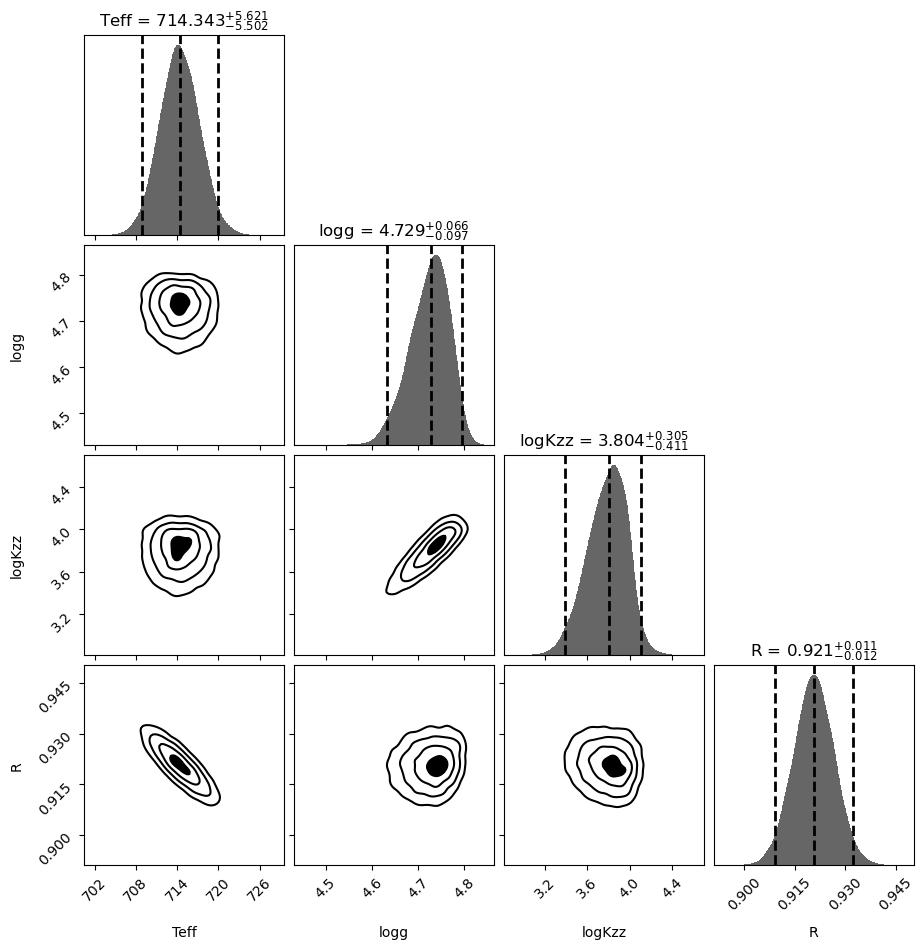

In [19]:
# plot the 2-D marginalized posteriors.
labels = list(out_bayes['my_bayes'].params_priors.keys())
fig, axes = dyplot.cornerplot(out_bayes['out_dynesty'], show_titles=True, 
                              verbose='true', title_fmt='.3f', 
                              title_kwargs={'y': 1.0}, labels=labels)

Plot a summary of the run

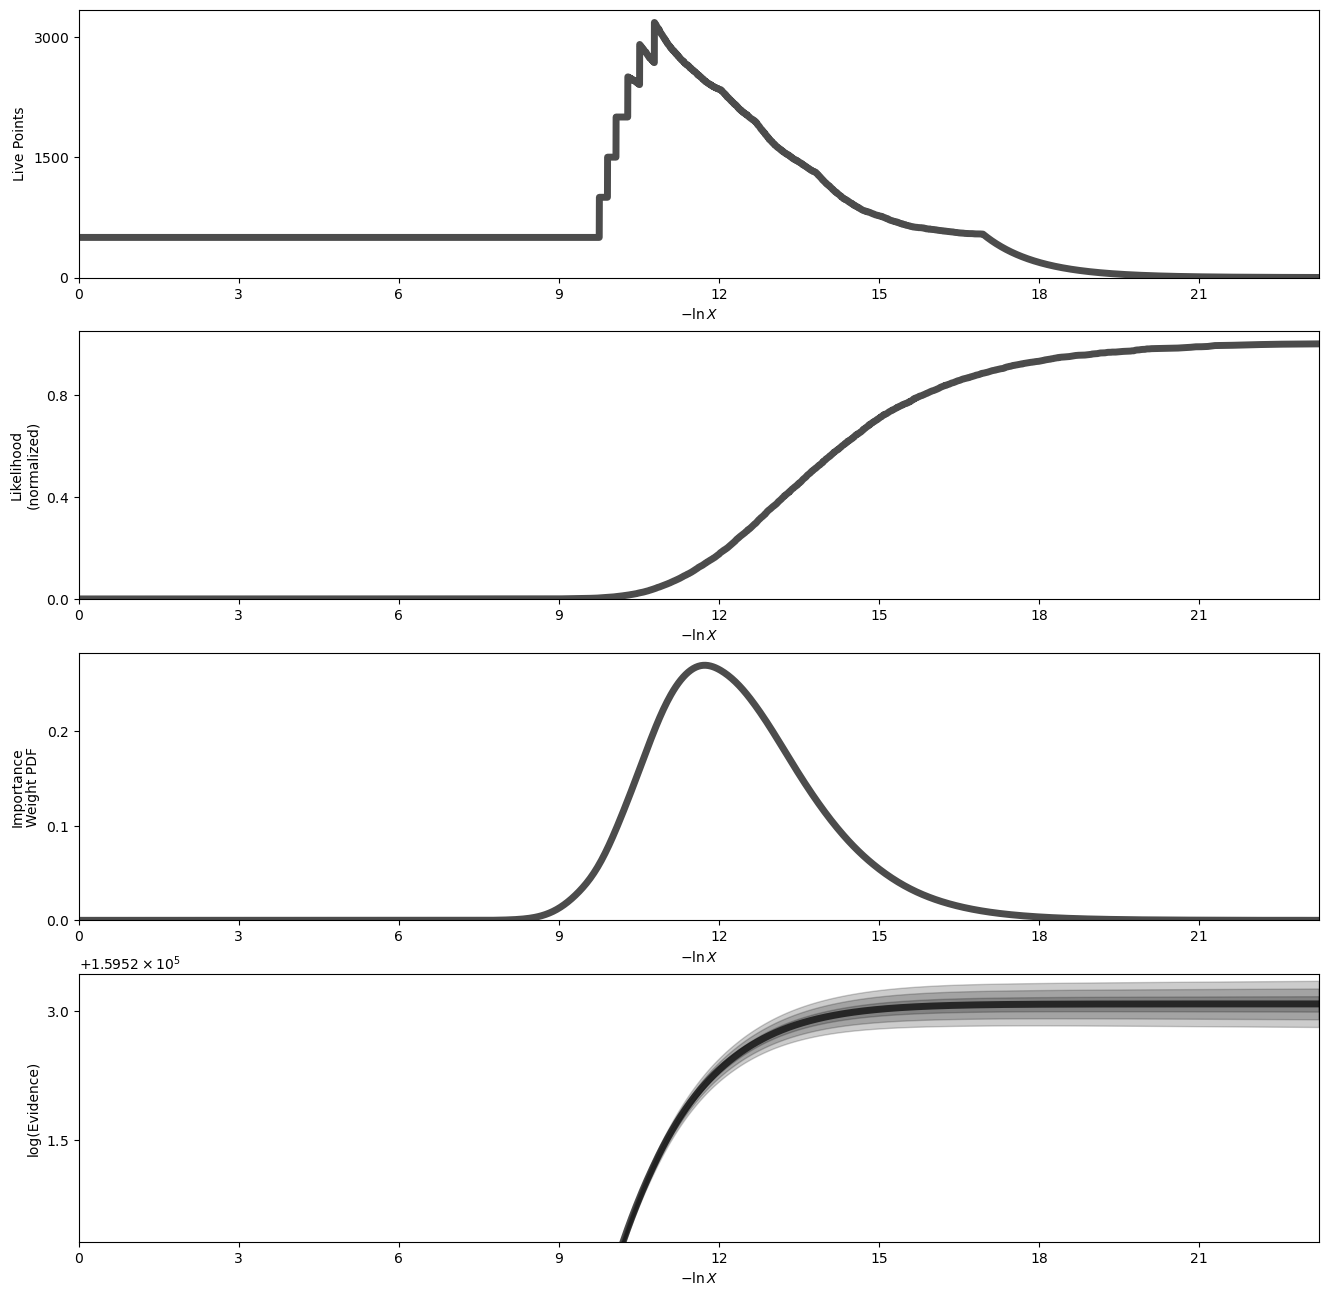

In [20]:
fig, axes = dyplot.runplot(out_bayes['out_dynesty'], color='black', 
                           mark_final_live=False, logplot=True)

Plot traces and 1-D marginalized posteriors

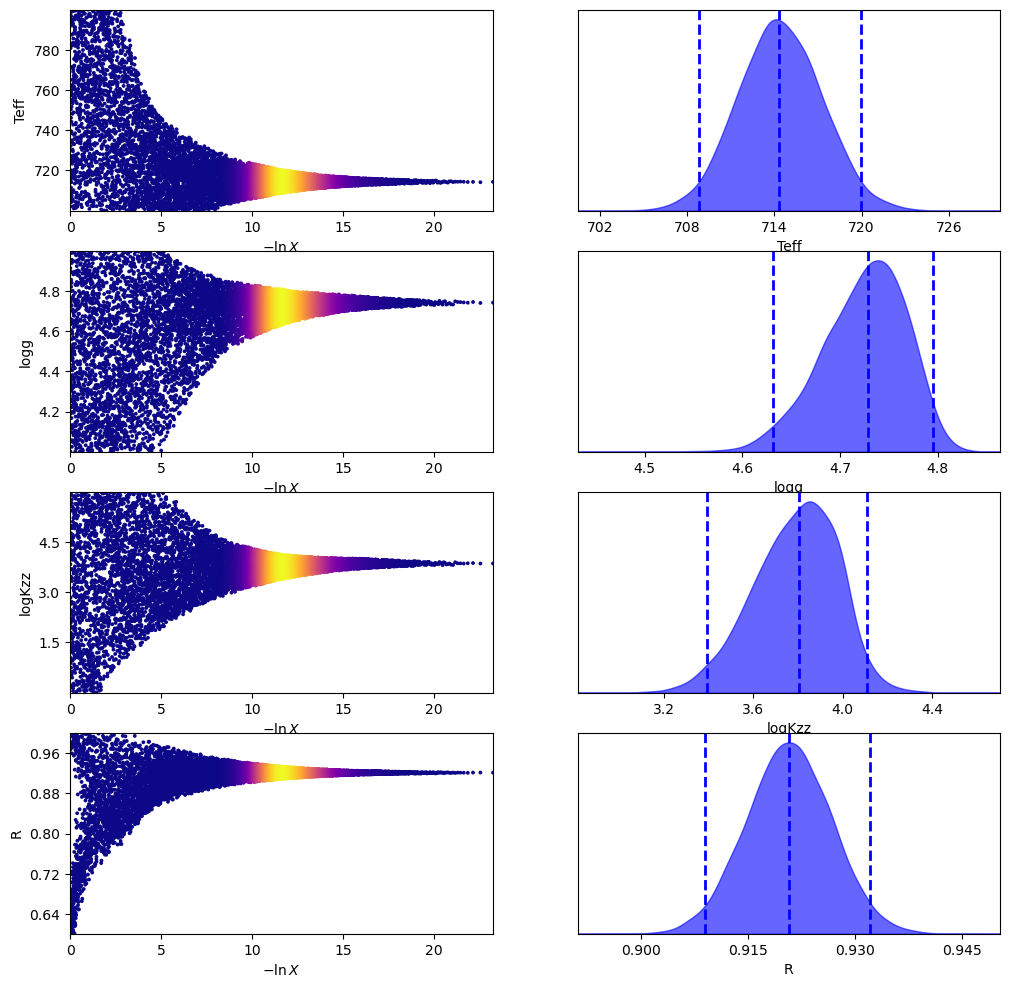

In [21]:
fig, axes = dyplot.traceplot(out_bayes['out_dynesty'], labels=labels)

**Plot the model spectrum using the median posterior parameters**

SED with the best model fit from the Bayesian sampling.

The pickle file generated by ``seda.bayes_fit.bayes`` and stored with the name ``my_bayes.bayes_pickle_file`` is the input file to make plots. We can provide the name by either using ``my_bayes.bayes_pickle_file`` (if ``my_bayes`` is in memory) or just typing it.

The best model fit will be generated by interpolating into a model grid subset around the median posteriors.


For input spectrum 1 of 3

      8 model spectra selected with:
         Teff range = [700. 800.]
         logg range = [4.5 5. ]
         logKzz range = [0. 4.]


Reading, convolving, and resampling model grid:   0%|          | 0/8 [00:00<?, ?it/s]

      elapsed time: 0.0 s

For input spectrum 2 of 3

      8 model spectra selected with:
         Teff range = [700. 800.]
         logg range = [4.5 5. ]
         logKzz range = [0. 4.]


Reading, convolving, and resampling model grid:   0%|          | 0/8 [00:00<?, ?it/s]

            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
      elapsed time: 0.0 s

For input spectrum 3 of 3

      8 model spectra selected with:
         Teff range = [700. 800.]
         logg range = [4.5 5. ]
         logKzz range = [0. 4.]


Reading, convolving, and resampling model grid:   0%|          | 0/8 [00:00<?, ?it/s]

      elapsed time: 0.0 s

      8 model spectra selected with:
         Teff range = [700. 800.]
         logg range = [4.5 5. ]
         logKzz range = [0. 4.]


Deriving synthetic photometry from model spectra:   0%|          | 0/8 [00:00<?, ?it/s]

      elapsed time: 24.0 s

      510 model spectra

      8 model spectra selected with:
         Teff range = [700. 800.]
         logg range = [4.5 5. ]
         logKzz range = [0. 4.]


Reading model grid:   0%|          | 0/8 [00:00<?, ?it/s]

      elapsed time: 0.0 s


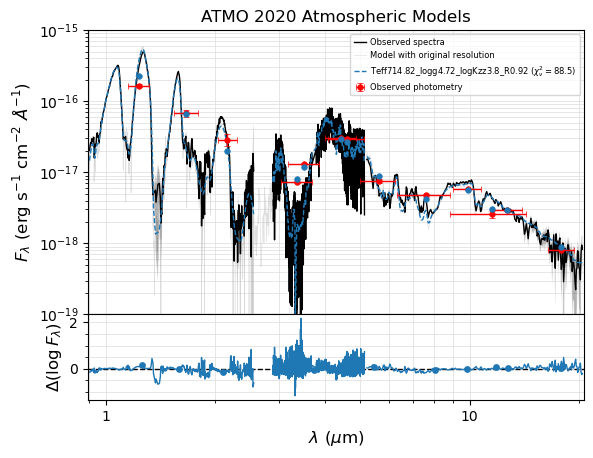

In [22]:
# using default logarithmic scale for fluxes
seda.plots.plot_bayes_fit(bayes_pickle_file, xlog=True, 
                          yrange=[1e-19, 1e-15],
                          ori_res=True)

Zoom in on the SpeX spectrum:


For input spectrum 1 of 3

      8 model spectra selected with:
         Teff range = [700. 800.]
         logg range = [4.5 5. ]
         logKzz range = [0. 4.]


Reading, convolving, and resampling model grid:   0%|          | 0/8 [00:00<?, ?it/s]

      elapsed time: 0.0 s

For input spectrum 2 of 3

      8 model spectra selected with:
         Teff range = [700. 800.]
         logg range = [4.5 5. ]
         logKzz range = [0. 4.]


Reading, convolving, and resampling model grid:   0%|          | 0/8 [00:00<?, ?it/s]

            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
      elapsed time: 0.0 s

For input spectrum 3 of 3

      8 model spectra selected with:
         Teff range = [700. 800.]
         logg range = [4.5 5. ]
         logKzz range = [0. 4.]


Reading, convolving, and resampling model grid:   0%|          | 0/8 [00:00<?, ?it/s]

      elapsed time: 0.0 s

      8 model spectra selected with:
         Teff range = [700. 800.]
         logg range = [4.5 5. ]
         logKzz range = [0. 4.]


Deriving synthetic photometry from model spectra:   0%|          | 0/8 [00:00<?, ?it/s]

      elapsed time: 26.0 s

      510 model spectra

      8 model spectra selected with:
         Teff range = [700. 800.]
         logg range = [4.5 5. ]
         logKzz range = [0. 4.]


Reading model grid:   0%|          | 0/8 [00:00<?, ?it/s]

      elapsed time: 0.0 s


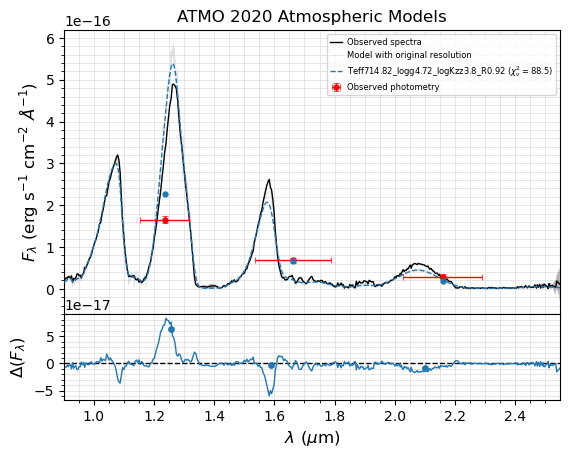

In [23]:
# plot fluxes in linear scale
seda.plots.plot_bayes_fit(bayes_pickle_file, ylog=False,
                          xrange=[wl_SpeX.min(), wl_SpeX.max()],
                          ori_res=True)

Zoom in on the NIRSpec spectrum:


For input spectrum 1 of 3

      8 model spectra selected with:
         Teff range = [700. 800.]
         logg range = [4.5 5. ]
         logKzz range = [0. 4.]


Reading, convolving, and resampling model grid:   0%|          | 0/8 [00:00<?, ?it/s]

      elapsed time: 0.0 s

For input spectrum 2 of 3

      8 model spectra selected with:
         Teff range = [700. 800.]
         logg range = [4.5 5. ]
         logKzz range = [0. 4.]


Reading, convolving, and resampling model grid:   0%|          | 0/8 [00:00<?, ?it/s]

            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
      elapsed time: 0.0 s

For input spectrum 3 of 3

      8 model spectra selected with:
         Teff range = [700. 800.]
         logg range = [4.5 5. ]
         logKzz range = [0. 4.]


Reading, convolving, and resampling model grid:   0%|          | 0/8 [00:00<?, ?it/s]

      elapsed time: 0.0 s

      8 model spectra selected with:
         Teff range = [700. 800.]
         logg range = [4.5 5. ]
         logKzz range = [0. 4.]


Deriving synthetic photometry from model spectra:   0%|          | 0/8 [00:00<?, ?it/s]

      elapsed time: 29.0 s

      510 model spectra

      8 model spectra selected with:
         Teff range = [700. 800.]
         logg range = [4.5 5. ]
         logKzz range = [0. 4.]


Reading model grid:   0%|          | 0/8 [00:00<?, ?it/s]

      elapsed time: 0.0 s


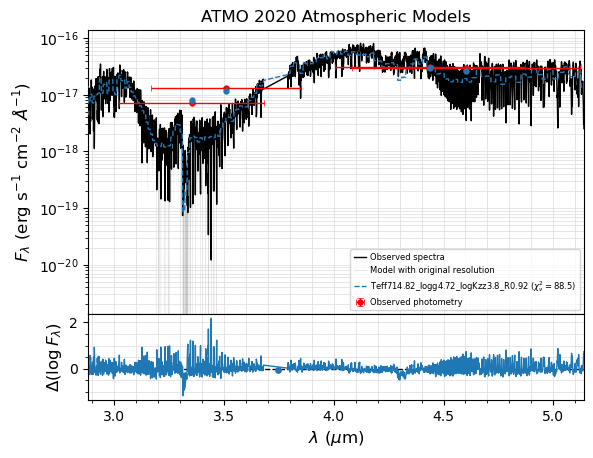

In [24]:
# plot fluxes in log scale
seda.plots.plot_bayes_fit(bayes_pickle_file, 
                          xrange=[wl_NIRSpec.min(), wl_NIRSpec.max()],
                          ori_res=True)

Zoom in on the IRS spectrum:


For input spectrum 1 of 3

      8 model spectra selected with:
         Teff range = [700. 800.]
         logg range = [4.5 5. ]
         logKzz range = [0. 4.]


Reading, convolving, and resampling model grid:   0%|          | 0/8 [00:00<?, ?it/s]

      elapsed time: 0.0 s

For input spectrum 2 of 3

      8 model spectra selected with:
         Teff range = [700. 800.]
         logg range = [4.5 5. ]
         logKzz range = [0. 4.]


Reading, convolving, and resampling model grid:   0%|          | 0/8 [00:00<?, ?it/s]

            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
            the spectrum will be convolved but will be essentially the same.
      elapsed time: 0.0 s

For input spectrum 3 of 3

      8 model spectra selected with:
         Teff range = [700. 800.]
         logg range = [4.5 5. ]
         logKzz range = [0. 4.]


Reading, convolving, and resampling model grid:   0%|          | 0/8 [00:00<?, ?it/s]

      elapsed time: 0.0 s

      8 model spectra selected with:
         Teff range = [700. 800.]
         logg range = [4.5 5. ]
         logKzz range = [0. 4.]


Deriving synthetic photometry from model spectra:   0%|          | 0/8 [00:00<?, ?it/s]

      elapsed time: 29.0 s

      510 model spectra

      8 model spectra selected with:
         Teff range = [700. 800.]
         logg range = [4.5 5. ]
         logKzz range = [0. 4.]


Reading model grid:   0%|          | 0/8 [00:00<?, ?it/s]

      elapsed time: 0.0 s


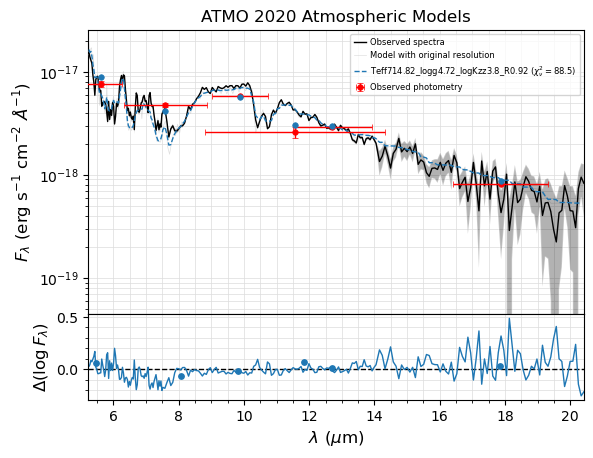

In [25]:
# plot fluxes in log scale
seda.plots.plot_bayes_fit(bayes_pickle_file, 
                          xrange=[wl_IRS.min(), wl_IRS.max()],
                          ori_res=True)